## Application of BPR on Zazzle data

In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
from subprocess import call
from pybpr import *
import matplotlib.pyplot as plt
from functools import partial

In [3]:
%%time
data_dir = os.path.join(os.path.curdir, 'data', 'zazzle')
df = pd.read_parquet(os.path.join(os.path.join(data_dir,'BPR_0005_part_00.parquet')))
df.columns
#print(df.memory_usage().sum() / 1024 / 1024)

CPU times: user 3.98 s, sys: 1.92 s, total: 5.9 s
Wall time: 2.55 s


Index(['product_id', 'user_id', 'click_created', 'search_url',
       'search_created', 'title', 'long_description', 'final_department_id',
       'price_us_usd', 'date_created', 'date_modified', 'is_customizable',
       'seller_id', 'store_id', 'group_id', 'product_url_en_us',
       'product_design_image_url_en_us', 'product_image_url_en_us',
       'product_type'],
      dtype='object')

In [4]:
print(df.memory_usage().sum() / 1024 / 1024)

616.9274301528931


In [5]:
df.user_id.nunique(), df.product_id.nunique()

(350388, 11401)

In [6]:
%%time
cf = UserItemInteractions(
    name='Zazzle',
    users=df['user_id'],
    items=df['product_id'],
    min_num_rating_per_user=200,
    min_num_rating_per_item=50,
    num_cores = 1
)
cf.print_memory_usage()

--- Memory usage for Zazzle:
Sparse User-Item matrix = 0.01 MB
User-Item dataframe df = 47.27 MB
Item dataframe df_item = 0.4 MB
Item dataframe df_user = 10.77 MB
---
CPU times: user 3.18 s, sys: 210 ms, total: 3.39 s
Wall time: 3.38 s


In [7]:
cf.num_users, cf.num_items, cf.sparsity

(1780, 3284, 0.295093)

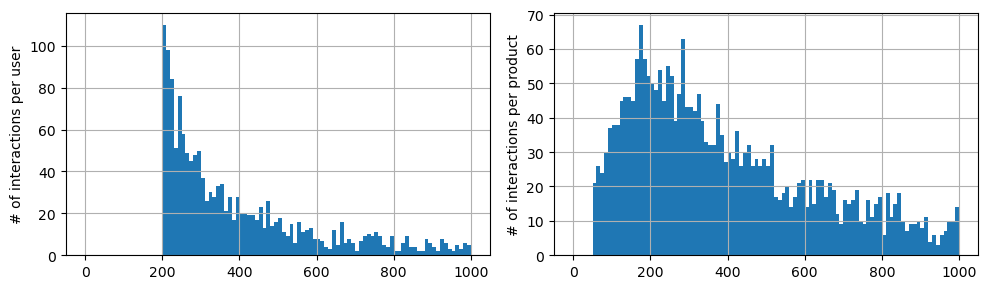

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
ax = ax.flatten()
cf.df_user.NumRatings.hist(bins=100, ax=ax[0], range=(0,1000))
#cf.df_user.NumRatings.divide(cf.num_items).hist(bins=100, ax=ax[0], range=(0,0.01))
ax[0].set_ylabel('# of interactions per user')
cf.df_item.NumRatings.hist(bins=100, ax=ax[1], range=(0,1000))
#cf.df_item.NumRatings.divide(cf.num_users).hist(bins=100, ax=ax[1], range=(0,0.01))
ax[1].set_ylabel('# of interactions per product')
fig.tight_layout()

In [102]:
%%time
cf.generate_train_test(user_test_ratio=0.1)

CPU times: user 3.45 s, sys: 563 µs, total: 3.45 s
Wall time: 3.45 s


In [114]:
%%time
bpr = BPR(
    num_features=20,
    reg_lambda=0.,
    num_iters=200,
    learning_rate = 0.4,
    batch_size=10,
    initial_std=0.001,
    seed=None
)
bpr_ndcg_func = partial(
    cf.get_ndcg_metric,
    num_items=10,
    truncate=False
)
bpr.fit(cf.R, ndcg_func=bpr_ndcg_func)

BPR: 100%|██████████████████████████████████████████████| 200/200 [08:19<00:00,  2.50s/it]

CPU times: user 1h 16min 21s, sys: 3h 8min 29s, total: 4h 24min 50s
Wall time: 8min 20s


Text(0, 0.5, 'NDCG@10 Testing')

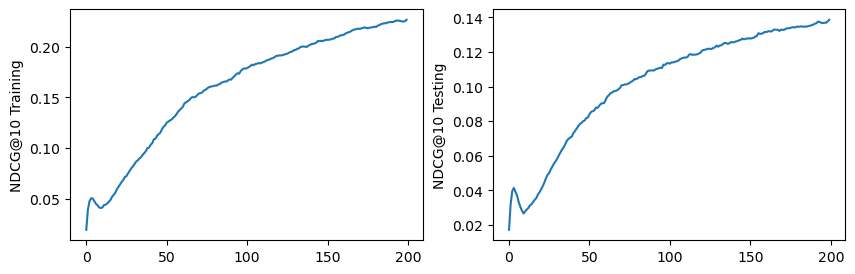

In [115]:
ndcg_df = pd.DataFrame(bpr.ndcg_metric)
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(ndcg_df['train'])
ax[0].set_ylabel('NDCG@10 Training')
ax[1].plot(ndcg_df['test'])
ax[1].set_ylabel('NDCG@10 Testing')

In [105]:
ndcg_df

,test,train
0,0.001648,0.001291
1,0.002865,0.002421
2,0.005343,0.005043
3,0.010364,0.008655
4,0.017160,0.013694
5,0.022928,0.020551
6,0.028321,0.025273
7,0.033239,0.030047
8,0.037117,0.035687
9,0.040470,0.040793


In [79]:
bpr_ndcg_func(test=True), bpr_ndcg_func(test=False)

TypeError: UserItemInteractions.get_ndcg_metric() missing 2 required positional arguments: 'user_mat' and 'item_mat'